# –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–π –∫–æ–¥

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epo—Åhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epo—Åhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epo—Åhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epo—Åhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epo—Åhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epo—Åhs"]))
                    ax[2].set_xticklabels(np.arange(history["epo—Åhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
import torch.nn as nn

class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs ‚Äúmanually‚Äù
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

model_name = "batchnorm_increased_lr"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π

–í –ø—Ä–æ—Ü–µ—Å—Å–µ –æ–±—É—á–µ–Ω–∏—è –º—ã –ø—ã—Ç–∞–µ–º—Å—è –ø–æ–¥–æ–±—Ä–∞—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–∏, –ø—Ä–∏ –∫–æ—Ç–æ—Ä—ã—Ö –æ–Ω–∞ –±—É–¥–µ—Ç —Ä–∞–±–æ—Ç–∞—Ç—å –ª—É—á—à–µ –≤—Å–µ–≥–æ. –≠—Ç–æ ‚Äî **–æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–æ–Ω–Ω–∞—è –∑–∞–¥–∞—á–∞** (–∑–∞–¥–∞—á–∞ –ø–æ–¥–±–æ—Ä–∞ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤). –ú—ã —É–∂–µ –æ–∑–Ω–∞–∫–æ–º–∏–ª–∏—Å—å —Å –æ–¥–Ω–∏–º –∞–ª–≥–æ—Ä–∏—Ç–º–æ–º –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ ‚Äî **–≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–º —Å–ø—É—Å–∫–æ–º**.

–°—É—â–µ—Å—Ç–≤—É–µ—Ç –º–Ω–æ–∂–µ—Å—Ç–≤–æ **–∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏**, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –ø—Ä–∏–º–µ–Ω—è—Ç—å –¥–ª—è –ø–æ–∏—Å–∫–∞ –º–∏–Ω–∏–º—É–º–∞ —Ñ—É–Ω–∫—Ü–∏–æ–Ω–∞–ª–∞ –æ—à–∏–±–∫–∏ ([–Ω–µ–ø–æ–ª–Ω—ã–π —Å–ø–∏—Å–æ–∫ üéì[article]](https://paperswithcode.com/methods/category/stochastic-optimization)). –≠—Ç–∏ –∞–ª–≥–æ—Ä–∏—Ç–º—ã —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω—ã –≤ –º–æ–¥—É–ª–µ `torch.optim` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/optim.html).

–í–∞–∂–Ω–æ –æ—Ç–º–µ—Ç–∏—Ç—å, —á—Ç–æ **–≤—ã–±–æ—Ä –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –Ω–µ –≤–ª–∏—è–µ—Ç –Ω–∞ —Ä–∞—Å—á–µ—Ç –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞**. –ì—Ä–∞–¥–∏–µ–Ω—Ç –≤ PyTorch –≤—ã—á–∏—Å–ª—è–µ—Ç—Å—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≥—Ä–∞—Ñ–∞ –≤—ã—á–∏—Å–ª–µ–Ω–∏–π.


## –û–±–∑–æ—Ä –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤

### SGD (stochastic gradient descent)

–ü—Ä–∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–º —Å–ø—É—Å–∫–µ –º—ã:
- –¥–µ–ª–∞–µ–º **–ø—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥**, –≤—ã—á–∏—Å–ª—è–µ–º —Ñ—É–Ω–∫—Ü–∏–æ–Ω–∞–ª –æ—à–∏–±–∫–∏ $\large L(x, y, w_t)$;
- –¥–µ–ª–∞–µ–º **–æ–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥**, –≤—ã—á–∏—Å–ª—è–µ–º –≥—Ä–∞–¥–∏–µ–Ω—Ç $\large \nabla_wL(x, y, w_t)$;
- –¥–µ–ª–∞–µ–º **—à–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏**: –∏–∑–º–µ–Ω—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–¥–µ–ª–∏ –ø–æ —Ñ–æ—Ä–º—É–ª–µ:

$$\large w_{t+1} = w_t - \text{lr} \cdot \nabla_wL(x, y, w_t),$$

–¥–æ–º–Ω–æ–∂–∞—è –∞–Ω—Ç–∏–≥—Ä–∞–¥–∏–µ–Ω—Ç –Ω–∞ –ø–æ—Å—Ç–æ—è–Ω–Ω—ã–π –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç $\text{lr}$ (–≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä –æ–±—É—á–µ–Ω–∏—è ‚Äî learning rate).

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stochastic_gradient_descent.gif" width="950">

–£ –¥–∞–Ω–Ω–æ–≥–æ –∞–ª–≥–æ—Ä–∏—Ç–º–∞ –µ—Å—Ç—å –ø—Ä–æ–±–ª–µ–º–∞: –æ–Ω –º–æ–∂–µ—Ç –∑–∞—Å—Ç—Ä–µ–≤–∞—Ç—å –≤ **–ª–æ–∫–∞–ª—å–Ω—ã—Ö –º–∏–Ω–∏–º—É–º–∞—Ö** –∏–ª–∏ –¥–∞–∂–µ **—Å–µ–¥–ª–æ–≤—ã—Ö —Ç–æ—á–∫–∞—Ö**.

**C–µ–¥–ª–æ–≤—ã–µ —Ç–æ—á–∫–∏** ‚Äî —Ç–æ—á–∫–∏, –≤ –∫–æ—Ç–æ—Ä—ã—Ö –≤—Å–µ –ø—Ä–æ–∏–∑–≤–æ–¥–Ω—ã–µ —Ä–∞–≤–Ω—ã $0$, –Ω–æ –æ–Ω–∏ –Ω–µ —è–≤–ª—è—é—Ç—Å—è —ç–∫—Å—Ç—Ä–µ–º—É–º–∞–º–∏. –í –Ω–∏—Ö –≥—Ä–∞–¥–∏–µ–Ω—Ç —Ä–∞–≤–µ–Ω $0$, –≤–µ—Å–∞ –Ω–µ –æ–±–Ω–æ–≤–ª—è—é—Ç—Å—è ‚Äî –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –æ—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ—Ç—Å—è.

–ü—Ä–∏–º–µ—Ä —Ç–∞–∫–∏—Ö —Ç–æ—á–µ–∫:

- —Ç–æ—á–∫–∞ $(0, 0)$ —É —Ñ—É–Ω–∫—Ü–∏–∏ $y = x^3$, –Ω–µ –∏–º–µ—é—â–µ–π –º–∏–Ω–∏–º—É–º–∞ –∏–ª–∏ –º–∞–∫—Å–∏–º—É–º–∞ –≤–æ–≤—Å–µ;
- —Ç–æ—á–∫–∞ $(0, 0, 0)$ —É —Ñ—É–Ω–∫—Ü–∏–∏ $z = x^2 - y^2$.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/getting_stuck_in_local_minimum_example.png" width="350"> <img src ="https://ml.gan4x4.ru/msu/dep-2.1/L07/saddle_point_example.png" width="400"></center>

<center><em>Source: <a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B4%D0%BB%D0%BE%D0%B2%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BA%D0%B0">–°–µ–¥–ª–æ–≤–∞—è —Ç–æ—á–∫–∞</a></em></center>

–ß–∞—Å—Ç–∏—á–Ω–æ —ç—Ç—É –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∞–µ—Ç **—Å—Ç–æ—Ö–∞—Å—Ç–∏—á–µ—Å–∫–∏–π –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π —Å–ø—É—Å–∫** (stochastic gradient descent, **SGD**). –í –Ω–µ–º –¥–ª—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–≥–æ —Å–ø—É—Å–∫–∞ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –Ω–µ –≤—Å–µ –¥–∞–Ω–Ω—ã–µ, –∞ –Ω–µ–∫–æ—Ç–æ—Ä–∞—è –ø–æ–¥–≤—ã–±–æ—Ä–∫–∞ (mini-batch) –∏–ª–∏ –¥–∞–∂–µ –æ–¥–∏–Ω —ç–ª–µ–º–µ–Ω—Ç.


**SGD** –æ–±–ª–∞–¥–∞–µ—Ç –≤–∞–∂–Ω–æ–π –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç—å—é: –Ω–∞ –∫–∞–∂–¥–æ–º –æ–±—ä–µ–∫—Ç–µ –∏–ª–∏ –ø–æ–¥–≤—ã–±–æ—Ä–∫–µ (mini-batch) –ª–∞–Ω–¥—à–∞—Ñ—Ç —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –≤—ã–≥–ª—è–¥–∏—Ç –ø–æ-—Ä–∞–∑–Ω–æ–º—É. –ù–µ–∫–æ—Ç–æ—Ä—ã–µ –º–∏–Ω–∏–º—É–º—ã —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –∏ —Å–µ–¥–ª–æ–≤—ã–µ —Ç–æ—á–∫–∏ –º–æ–≥—É—Ç –±—ã—Ç—å —Ö–∞—Ä–∞–∫—Ç–µ—Ä–Ω—ã –ª–∏—à—å –¥–ª—è —á–∞—Å—Ç–∏ –æ–±—ä–µ–∫—Ç–æ–≤.

–ù–∏–∂–µ **—É–ø—Ä–æ—â–µ–Ω–Ω–æ** –ø–æ–∫–∞–∑–∞–Ω—ã –ª–∞–Ω–¥—à–∞—Ñ—Ç—ã —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –Ω–∞ –ø–æ–ª–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –∏ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –±–∞—Ç—á–∞—Ö. –ü—Ä–∏ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –Ω–∞ –ø–æ–ª–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ –º–æ–¥–µ–ª—å –º–æ–≥–ª–∞ –±—ã **–æ—Å—Ç–∞–Ω–æ–≤–∏—Ç—å—Å—è –≤ –ª–µ–≤–æ–º –ª–æ–∫–∞–ª—å–Ω–æ–º –º–∏–Ω–∏–º—É–º–µ**, –Ω–æ —Å—Ç–æ—Ö–∞—Å—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–∏—Ä–æ–¥–∞ —Å–ø—É—Å–∫–∞ –ø–æ–∑–≤–æ–ª—è–µ—Ç –∏–∑–±–µ–∂–∞—Ç—å —ç—Ç–æ–≥–æ –∑–∞ —Å—á–µ—Ç —Ç–æ–≥–æ, —á—Ç–æ **–¥–ª—è –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –±–∞—Ç—á–µ–π —ç—Ç–æ—Ç –º–∏–Ω–∏–º—É–º –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç**.

–í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –º–æ–¥–µ–ª—å —Å–º–æ–∂–µ—Ç –æ—Å—Ç–∞–Ω–æ–≤–∏—Ç—å—Å—è —Ç–æ–ª—å–∫–æ –≤ –∫–∞–∫–æ–º-—Ç–æ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ —à–∏—Ä–æ–∫–æ–º –∏ –≥–ª—É–±–æ–∫–æ–º –º–∏–Ω–∏–º—É–º–µ, —Ö–∞—Ä–∞–∫—Ç–µ—Ä–Ω–æ–º –¥–ª—è –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–∞ –±–∞—Ç—á–µ–π –æ–±—É—á–∞—é—â–∏—Ö –¥–∞–Ω–Ω—ã—Ö. –° –±–æ–ª—å—à–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é —ç—Ç–æ—Ç –º–∏–Ω–∏–º—É–º –±—É–¥–µ—Ç –ø—Ä–∏—Å—É—Ç—Å—Ç–≤–æ–≤–∞—Ç—å –∏ –Ω–∞ —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö, —Ç–æ –µ—Å—Ç—å –º–æ–¥–µ–ª—å —Å–º–æ–∂–µ—Ç –∞–¥–µ–∫–≤–∞—Ç–Ω–æ —Ä–∞–±–æ—Ç–∞—Ç—å —Å –Ω–∏–º–∏.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/sgd_loss_batch_landscape.png" width="700"></center>

**SGD** –¥–æ —Å–∏—Ö –ø–æ—Ä —è–≤–ª—è–µ—Ç—Å—è –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –ø–æ–ø—É–ª—è—Ä–Ω—ã–º –º–µ—Ç–æ–¥–æ–º –æ–±—É—á–µ–Ω–∏—è –Ω–µ–π—Ä–æ—Å–µ—Ç–µ–π, –ø–æ—Ç–æ–º—É —á—Ç–æ –æ–Ω –ø—Ä–æ—Å—Ç–æ–π, –Ω–µ —Ç—Ä–µ–±—É–µ—Ç –ø–æ–¥–±–æ—Ä–∞ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, –∫—Ä–æ–º–µ **—Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è** `lr`, –∏ —Å–∞–º –ø–æ —Å–µ–±–µ –æ–±—ã—á–Ω–æ –¥–∞–µ—Ç –Ω–µ–ø–ª–æ—Ö–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã.

–ï—Å–ª–∏ –∂–µ –º–æ–¥–µ–ª—å —É—á–∏—Ç—Å—è —Å–ª–∏—à–∫–æ–º –¥–æ–ª–≥–æ –∏/–∏–ª–∏ –≤–∞–∂–Ω–∞ –∫–∞–∂–¥–∞—è —Å–æ—Ç–∞—è –≤ –∫–∞—á–µ—Å—Ç–≤–µ, —Ç–æ –Ω—É–∂–Ω–æ –ª–∏–±–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –µ–≥–æ –≤ —Å–æ–≤–æ–∫—É–ø–Ω–æ—Å—Ç–∏ —Å –¥—Ä—É–≥–∏–º–∏ —Ç–µ—Ö–Ω–∏–∫–∞–º–∏ (–∏—Ö —Ä–∞—Å—Å–º–æ—Ç—Ä–∏–º –¥–∞–ª–µ–µ), –ª–∏–±–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥—Ä—É–≥–∏–µ —Å–ø–æ—Å–æ–±—ã.

–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã SGD:
```python
class SGD:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def step(self):
    d_parameters = self.parameters.grad
    self.parameters -= self.lr*d_parameters
```

–ê–ª–≥–æ—Ä–∏—Ç–º SGD —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.SGD` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
import torch.optim as optim

parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001)

**–ú–∏–Ω—É—Å—ã SGD**:

 1. –ï—Å–ª–∏ —Ñ—É–Ω–∫—Ü–∏—è –æ—à–∏–±–∫–∏ –≤ –æ–¥–Ω–æ–º –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–∏ –º–µ–Ω—è–µ—Ç—Å—è –±—ã—Å—Ç—Ä–æ, –∞ –≤ –¥—Ä—É–≥–æ–º ‚Äî –º–µ–¥–ª–µ–Ω–Ω–æ, —Ç–æ —ç—Ç–æ –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ —Ä–µ–∑–∫–∏–º –∏–∑–º–µ–Ω–µ–Ω–∏—è–º –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –∏ –∑–∞–º–µ–¥–ª—è–µ—Ç –ø—Ä–æ—Ü–µ—Å—Å –æ–±—É—á–µ–Ω–∏—è.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"></center>


 2. –ú–æ–∂–µ—Ç –∑–∞—Å—Ç—Ä–µ–≤–∞—Ç—å –≤ –ª–æ–∫–∞–ª—å–Ω—ã—Ö –º–∏–Ω–∏–º—É–º–∞—Ö –∏–ª–∏ —Å–µ–¥–ª–æ–≤—ã—Ö —Ç–æ—á–∫–∞—Ö.

 3. –ú—ã –æ—Ü–µ–Ω–∏–≤–∞–µ–º –≥—Ä–∞–¥–∏–µ–Ω—Ç –ø–æ –º–∞–ª—ã–º —á–∞—Å—Ç—è–º –≤—ã–±–æ—Ä–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç –ø–ª–æ—Ö–æ –æ—Ç–æ–±—Ä–∞–∂–∞—Ç—å –≥—Ä–∞–¥–∏–µ–Ω—Ç –ø–æ –≤—Å–µ–π –≤—ã–±–æ—Ä–∫–µ –∏ —è–≤–ª—è—Ç—å—Å—è —à—É–º–Ω—ã–º–∏. –í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ —á–∞—Å—Ç—å —à–∞–≥–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–≥–æ —Å–ø—É—Å–∫–∞ –¥–µ–ª–∞–µ—Ç—Å—è –≤–ø—É—Å—Ç—É—é –∏–ª–∏ –≤–æ –≤—Ä–µ–¥.

 4. –ú—ã –ø—Ä–∏–º–µ–Ω—è–µ–º –æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ `learning rate` –∫–æ –≤—Å–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º, —á—Ç–æ –Ω–µ –≤—Å–µ–≥–¥–∞ —Ä–∞–∑—É–º–Ω–æ. –ü–∞—Ä–∞–º–µ—Ç—Ä, –æ—Ç–≤–µ—á–∞—é—â–∏–π —Ä–µ–¥–∫–æ–º—É –∫–ª–∞—Å—Å—É, –±—É–¥–µ—Ç –æ–±—É—á–∞—Ç—å—Å—è –º–µ–¥–ª–µ–Ω–Ω–µ–µ –æ—Å—Ç–∞–ª—å–Ω—ã—Ö.

 5. –ü—Ä–æ—Å—Ç–æ –º–µ–¥–ª–µ–Ω–Ω–µ–µ —Å—Ö–æ–¥–∏—Ç—Å—è.

**SGD** —è–≤–ª—è–µ—Ç—Å—è –æ—Å–Ω–æ–≤–æ–π –≤—Å–µ—Ö –æ–ø–∏—Å–∞–Ω–Ω—ã—Ö –Ω–∏–∂–µ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤.

### Momentum

–ß—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –ø—Ä–æ–±–ª–µ–º 1‚Äì3, –º–æ–∂–Ω–æ –¥–æ–±–∞–≤–∏—Ç—å –¥–≤–∏–∂–µ–Ω–∏—é –ø–æ –ª–∞–Ω–¥—à–∞—Ñ—Ç—É —Ñ—É–Ω–∫—Ü–∏–∏ –æ—à–∏–±–æ–∫ –∏–Ω–µ—Ä—Ü–∏—é (**momentum**). –ü–æ –∞–Ω–∞–ª–æ–≥–∏–∏ —Å —Ä–µ–∞–ª—å–Ω–æ–π –∂–∏–∑–Ω—å—é: –µ—Å–ª–∏ –º—è—á –∫–∞—Ç–∏—Ç—Å—è —Å –≥–æ—Ä–∫–∏, —Ç–æ –æ–Ω –±–ª–∞–≥–æ–¥–∞—Ä—è –∏–Ω–µ—Ä—Ü–∏–∏ –º–æ–∂–µ—Ç –ø—Ä–æ—Å–∫–æ—á–∏—Ç—å –ø–æ–ª–æ–≥–æ–µ –º–µ—Å—Ç–æ –∏–ª–∏ –¥–∞–∂–µ –Ω–µ–±–æ–ª—å—à—É—é —è–º—É.

–ö–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –¥–≤–∏–∂–µ–Ω–∏—è —à–∞—Ä–∏–∫–∞ —Å —É—á–µ—Ç–æ–º —Ç–µ–∫—É—â–µ–≥–æ –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞:

$$\large v_{t} = m \cdot v_{t-1} + \nabla_wL(x, y, w_{t}),$$

–≥–¥–µ $m \in [0, 1)$ ‚Äî momentum (–≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä).

–í—ã—á–∏—Å–ª—è–µ–º, –∫—É–¥–∞ –æ–Ω –ø–æ–∫–∞—Ç–∏—Ç—Å—è:

$$\large w_{t+1} = w_t - lr \cdot v_{t}$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/advantages_wtih_momentum.png" width="480"></center>

[[video] üì∫ –ì—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π —Å–ø—É—Å–∫, –∫–∞–∫ –æ–±—É—á–∞—é—Ç—Å—è –Ω–µ–π—Ä–æ–Ω–Ω—ã–µ —Å–µ—Ç–∏](https://youtu.be/IHZwWFHWa-w)

–¢–µ–ø–µ—Ä—å –º—ã –±—ã—Å—Ç—Ä–µ–µ –¥–æ—Å—Ç–∏–≥–∞–µ–º –ª–æ–∫–∞–ª—å–Ω–æ–≥–æ –º–∏–Ω–∏–º—É–º–∞ –∏ –º–æ–∂–µ–º –≤—ã–∫–∞—Ç—ã–≤–∞—Ç—å—Å—è –∏–∑ —Å–æ–≤—Å–µ–º –Ω–µ–≥–ª—É–±–æ–∫–∏—Ö. –ì—Ä–∞–¥–∏–µ–Ω—Ç —Å—Ç–∞–ª –º–µ–Ω–µ–µ –ø–æ–¥–≤–µ—Ä–∂–µ–Ω —à—É–º—É, –º–µ–Ω—å—à–µ –æ—Å—Ü–∏–ª–ª–∏—Ä—É–µ—Ç

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"> <img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/stohastic_gradient_descent_with_momentum.gif" width="500">

–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã Momentum:

```python
class SGD_with_momentum:
  def __init__(self, parameters, momentum, lr):
    self.parameters = parameters
    self.momentum = momentum
    self.lr = lr
    self.velocity = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.velocity =  self.momentum*self.velocity + d_parameters
    self.weights -= self.lr*self.velocity
```


**Momentum —É–¥–≤–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–ê–ª–≥–æ—Ä–∏—Ç–º Momentum —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.SGD` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)

–£ —ç—Ç–æ–≥–æ –ø–æ–¥—Ö–æ–¥–∞ –µ—Å—Ç—å –æ–¥–Ω–∞ –æ–ø–∞—Å–Ω–æ—Å—Ç—å ‚Äî –º—ã –º–æ–∂–µ–º –≤—ã–∫–∞—Ç–∏—Ç—å—Å—è –∑–∞ –ø—Ä–µ–¥–µ–ª—ã –º–∏–Ω–∏–º—É–º–∞, –∫ –∫–æ—Ç–æ—Ä–æ–º—É —Å—Ç—Ä–µ–º–∏–º—Å—è, –∞ –ø–æ—Ç–æ–º –∫–∞–∫–æ–µ-—Ç–æ –≤—Ä–µ–º—è –∫ –Ω–µ–º—É –≤–æ–∑–≤—Ä–∞—â–∞—Ç—å—Å—è.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/problem_of_big_momentum_value.gif" width="700">

<em>Source: <a href="https://distill.pub/2017/momentum/">Why Momentum Really Works</a></em></center>

[[demo] üéÆ Why Momentum Really Works](https://distill.pub/2017/momentum/)

–ß—Ç–æ–±—ã —Å —ç—Ç–∏–º –±–æ—Ä–æ—Ç—å—Å—è, –ø—Ä–µ–¥–ª–æ–∂–µ–Ω –¥—Ä—É–≥–æ–π —Å–ø–æ—Å–æ–± –ø–æ–¥—Å—á–µ—Ç–∞ –∏–Ω–µ—Ä—Ü–∏–∏.

### NAG (Nesterov momentum)

–ë—É–¥–µ–º —Å–Ω–∞—á–∞–ª–∞ —Å–º–µ—â–∞—Ç—å—Å—è –≤ —Å—Ç–æ—Ä–æ–Ω—É, –∫—É–¥–∞ –ø—Ä–∏–≤–µ–ª –±—ã –Ω–∞—Å –Ω–∞–∫–æ–ø–ª–µ–Ω–Ω—ã–π –≥—Ä–∞–¥–∏–µ–Ω—Ç, —Ç–∞–º —Å—á–∏—Ç–∞—Ç—å –Ω–æ–≤—ã–π –≥—Ä–∞–¥–∏–µ–Ω—Ç –∏ —Å–º–µ—â–∞—Ç—å—Å—è –ø–æ –Ω–µ–º—É.
–í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –ø–µ—Ä–µ—Å–∫–æ–∫–∏ —á–µ—Ä–µ–∑ –º–∏–Ω–∏–º—É–º –±—É–¥—É—Ç –º–µ–Ω–µ–µ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–º–∏ –∏ –∞–ª–≥–æ—Ä–∏—Ç–º –±—É–¥–µ—Ç –±—ã—Å—Ç—Ä–µ–µ —Å—Ö–æ–¥–∏—Ç—å—Å—è:

$$\large v_{t} = m \cdot v_{t-1} +  \nabla_w L(w_t - \text{lr} \cdot m \cdot  v_{t-1} )$$

$$\large w_{t+1} = w_{t} - \text{lr} \cdot v_{t} $$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/nesterov_momentum.png" width="800"></center>

–ö–∞–∂–µ—Ç—Å—è, —á—Ç–æ –¥–ª—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ç–∞–∫–æ–≥–æ –∞–ª–≥–æ—Ä–∏—Ç–º–∞ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–µ—Ä–µ—Å—á–∏—Ç—ã–≤–∞—Ç—å –ø—Ä—è–º–æ–π –∏ –æ–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥ —Å –Ω–æ–≤—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞. –ù–∞ –ø—Ä–∞–∫—Ç–∏–∫–µ —ç—Ç—É —Ñ–æ—Ä–º—É–ª—É –º–æ–∂–Ω–æ [–ø–µ—Ä–µ–ø–∏—Å–∞—Ç—å üéì[article]](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf) —Ç–∞–∫, —á—Ç–æ–±—ã –Ω–µ –ø–µ—Ä–µ—Å—á–∏—Ç—ã–≤–∞—Ç—å –≥—Ä–∞–¥–∏–µ–Ω—Ç.

–° –ø—Å–µ–≤–¥–æ–∫–æ–¥–æ–º, –æ–ø–∏—Å—ã–≤–∞—é—â–∏–º –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å –¥–µ–π—Å—Ç–≤–∏–π NAG, –º–æ–∂–Ω–æ –ø–æ–∑–Ω–∞–∫–æ–º–∏—Ç—å—Å—è –≤ [PyTorch üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

**–¢–∞–∫ –∂–µ, –∫–∞–∫ momentum, Nesterov momentum —É–¥–≤–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–ê–ª–≥–æ—Ä–∏—Ç–º Nesterov momentum —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.SGD` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=0.001)

### Adaptive Learning Rate

–û–ø–∏—Å–∞–Ω–Ω—ã–µ –∞–ª–≥–æ—Ä–∏—Ç–º—ã –Ω–µ –±–æ—Ä—é—Ç—Å—è —Å 4-–æ–π –ø—Ä–æ–±–ª–µ–º–æ–π SGD: "–º—ã –ø—Ä–∏–º–µ–Ω—è–µ–º **–æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ learning rate –∫–æ –≤—Å–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º**, —á—Ç–æ –Ω–µ –≤—Å–µ–≥–¥–∞ —Ä–∞–∑—É–º–Ω–æ. –ü–∞—Ä–∞–º–µ—Ç—Ä, –æ—Ç–≤–µ—á–∞—é—â–∏–π —Ä–µ–¥–∫–æ–º—É –∫–ª–∞—Å—Å—É, –±—É–¥–µ—Ç –æ–±—É—á–∞—Ç—å—Å—è –º–µ–¥–ª–µ–Ω–Ω–µ–µ –æ—Å—Ç–∞–ª—å–Ω—ã—Ö".

**–ü—Ä–∏–º–µ—Ä:** –º—ã —Ä–µ—à–∞–µ–º –∑–∞–¥–∞—á—É –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∫–∞—Ä—Ç–∏–Ω–æ–∫ –∏–∑ –ò–Ω—Ç–µ—Ä–Ω–µ—Ç–∞, –∏ —É –Ω–∞—Å –µ—Å—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω—ã–µ –∑–∞ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏–∑—É—é—Ç –∫–æ—à–µ–∫ –ø–æ—Ä–æ–¥—ã —Å—Ñ–∏–Ω–∫—Å. –ö–æ—à–∫–∏ –ø–æ—Ä–æ–¥—ã —Å—Ñ–∏–Ω–∫—Å –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –≤ –Ω–∞—à–µ–º –¥–∞—Ç–∞—Å–µ—Ç–µ —Ä–µ–¥–∫–æ, –∏ —ç—Ç–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ä–µ–∂–µ –ø–æ–ª—É—á–∞—é—Ç –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –¥–ª—è –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è. –ü–æ—ç—Ç–æ–º—É –Ω–∞—à–∞ –º–æ–¥–µ–ª—å –º–æ–∂–µ—Ç —Ö—É–∂–µ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –∫–æ—à–µ–∫ —ç—Ç–æ–π –ø–æ—Ä–æ–¥—ã.

–î–ª—è —Ä–µ—à–µ–Ω–∏—è —ç—Ç–æ–π –ø—Ä–æ–±–ª–µ–º—ã –º—ã –º–æ–∂–µ–º –∑–∞–≤–µ—Å—Ç–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ **–∏–Ω–¥–∏–≤–∏–¥—É–∞–ª—å–Ω—ã–π learning rate**, –∑–∞–≤–∏—Å—è—â–∏–π –æ—Ç —Ç–æ–≥–æ, –∫–∞–∫ —á–∞—Å—Ç–æ –∏ –∫–∞–∫ —Å–∏–ª—å–Ω–æ –∏–∑–º–µ–Ω—è–µ—Ç—Å—è —ç—Ç–æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä –≤ –ø—Ä–æ—Ü–µ—Å—Å–µ –æ–±—É—á–µ–Ω–∏—è.

### Adagrad

–ë—É–¥–µ–º —Ö—Ä–∞–Ω–∏—Ç—å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ **—Å—É–º–º—É –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –µ–≥–æ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤** (–∑–∞–ø–æ–º–∏–Ω–∞–µ–º, –∫–∞–∫ —á–∞—Å—Ç–æ –∏ –∫–∞–∫ —Å–∏–ª—å–Ω–æ –æ–Ω –∏–∑–º–µ–Ω—è–ª—Å—è).

–ò –±—É–¥–µ–º –≤—ã—á–∏—Ç–∞—Ç—å –∏–∑ –∑–Ω–∞—á–µ–Ω–∏–π –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç —Å –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º, –æ–±—Ä–∞—Ç–Ω–æ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–º –∫–æ—Ä–Ω—é –∏–∑ —ç—Ç–æ–π —Å—É–º–º—ã $G_t$.

$$\large G_ t = \sum_{i=1}^t \nabla_w L(x,y,w_i)\odot\nabla_w L(x,y,w_i), $$

$$\large w_{t+1} = w_{t} -  \frac{\text{lr}}{\sqrt{G_t} + e} \odot \nabla_w L(x,y,w_{t}), $$

–≥–¥–µ $e$ ‚Äî –º–∞–ª–∞—è –∫–æ–Ω—Å—Ç–∞–Ω—Ç–∞, —á—Ç–æ–±—ã –Ω–µ –¥–æ–ø—É—Å–∫–∞—Ç—å –¥–µ–ª–µ–Ω–∏—è –Ω–∞ –Ω–æ–ª—å, $\odot$ ‚Äî –ø–æ—ç–ª–µ–º–µ–Ω—Ç–Ω–æ–µ —É–º–Ω–æ–∂–µ–Ω–∏–µ.

–í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ, –µ—Å–ª–∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç —É –Ω–∞—à–µ–≥–æ –≤–µ—Å–∞ —á–∞—Å—Ç–æ –±–æ–ª—å—à–æ–π, –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –±—É–¥–µ—Ç —É–º–µ–Ω—å—à–∞—Ç—å—Å—è.

–ü—Ä–æ–±–ª–µ–º–∞ –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ —Ç–æ–º, —á—Ç–æ –ø—Ä–∏ —Ç–∞–∫–æ–π —Ñ–æ—Ä–º—É–ª–µ learning rate –Ω–µ–º–∏–Ω—É–µ–º–æ –≤ –∫–æ–Ω—Ü–µ –∫–æ–Ω—Ü–æ–≤ –∑–∞—Ç—É—Ö–∞–µ—Ç (—Ç–∞–∫ –∫–∞–∫ —Å—É–º–º–∞ –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –Ω–µ —É–±—ã–≤–∞–µ—Ç).


–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã Adagrad:
```python
class AdaGrad:
  def __init__(self, parameters, lr=0.01):
     self.parameters = parameters
     self.lr = lr
     self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared += d_parameters*d_parameters
    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adagrad —É–¥–≤–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–ê–ª–≥–æ—Ä–∏—Ç–º Adagrad —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.Adagrad` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

### RMSprop

–î–æ–±–∞–≤–∏–º "–∑–∞–±—ã–≤–∞–Ω–∏–µ" –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤. –¢–µ–ø–µ—Ä—å –º—ã —Å—á–∏—Ç–∞–µ–º –Ω–µ —Å—É–º–º—É –∫–≤–∞–¥—Ä–∞—Ç–æ–≤, –∞ [—ç–∫—Å–ø–æ–Ω–µ–Ω—Ü–∏–∞–ª—å–Ω–æ–µ —Å–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ üìö[wiki]](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) —Å –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º $\alpha$.


$$\large G_t = \alpha \cdot G_{t-1} + (1-\alpha) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t)$$

$$\large w_{t+1} = w_{t} - \frac{\text{lr}}{\sqrt{G_t }+ e} \odot \nabla_w L(x,y,w_t)$$

–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã RMSprop (Root Mean Square Propagation):

```python
class RMSprop():
  def __init__(self, parameters, lr=0.01, alpha=0.99):
    self.parameters = parameters
    self.lr = lr
    self.alpha = alpha
    self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared = self.alpha*self.grad_squared + \
        (1 - self.alpha)*d_parameters*d_parameters

    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**–¢–∞–∫ –∂–µ, –∫–∞–∫ Adagrad, RMSprop —É–¥–≤–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–ê–ª–≥–æ—Ä–∏—Ç–º RMSprop —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.RMSprop` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

### Adam

–û–¥–Ω–∏–º –∏–∑ —Å–∞–º—ã—Ö –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –∞–¥–∞–ø—Ç–∏–≤–Ω—ã—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤ —è–≤–ª—è–µ—Ç—Å—è Adam, –æ–±—ä–µ–¥–∏–Ω—è—é—â–∏–π –∏–¥–µ–∏ momentum –∏ adaptive learning rate:

$$\large v_t = \beta_1 \cdot v_{t-1} + (1-\beta_1) \cdot \nabla_w L(x,y,w_t),$$

$$\large G_t = \beta_2 \cdot G_{t-1} + (1-\beta_2) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t),$$

$$\large w_{t+1} = w_t - \frac{\text{lr}}{\sqrt{G_t} + e} \odot v_t,$$

–≥–¥–µ $\beta_1$ ‚Äî –∞–Ω–∞–ª–æ–≥ $m$ –∏–∑ Momentum, –∞ $\beta_2$ ‚Äî –∞–Ω–∞–ª–æ–≥ $\alpha$ –∏–∑ RMSprop.

–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã Adam:

```python
class Adam:
  def __init__(self, parameters, lr=0.01, betas=(0.9, 0.999)):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.grad_squared = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum
    self.beta_2 = betas[1] # alpha

  def step(self):
    d_parameters = self.parameters.grad
    # momentum
    self.velocity = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # adaptive learning rate
    self.grad_squared = self.beta_2*self.grad_squared + \
        (1 - self.beta_2)*d_parameters*d_parameters
    self.parameters -= self.lr*self.velocity / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adam —É—Ç—Ä–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–ß—Ç–æ–±—ã –≤ –Ω–∞—á–∞–ª–µ —É –Ω–∞—Å –ø–æ–ª—É—á–∞–ª–∏—Å—å –æ—á–µ–Ω—å –±–æ–ª—å—à–∏–µ —à–∞–≥–∏, –±—É–¥–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –º–æ–¥–∏—Ü–∏—Ñ–∏—Ä–æ–≤–∞—Ç—å –∏–Ω–µ—Ä—Ü–∏—é –∏ —Å—É–º–º—É –∫–≤–∞–¥—Ä–∞—Ç–æ–≤:

$$\large v_t = \frac{v_t}{1-\beta_1^t}, \qquad G_t = \frac{G_t}{1-\beta_2^t} $$

–ê–ª–≥–æ—Ä–∏—Ç–º Adam —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ `torch.optim.Adam` [üõ†Ô∏è[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adam([parameters], betas=(0.9, 0.999))

–ü—Ä–∏–º–µ—Ä –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è:

In [ ]:
model_name = "adam"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-2},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


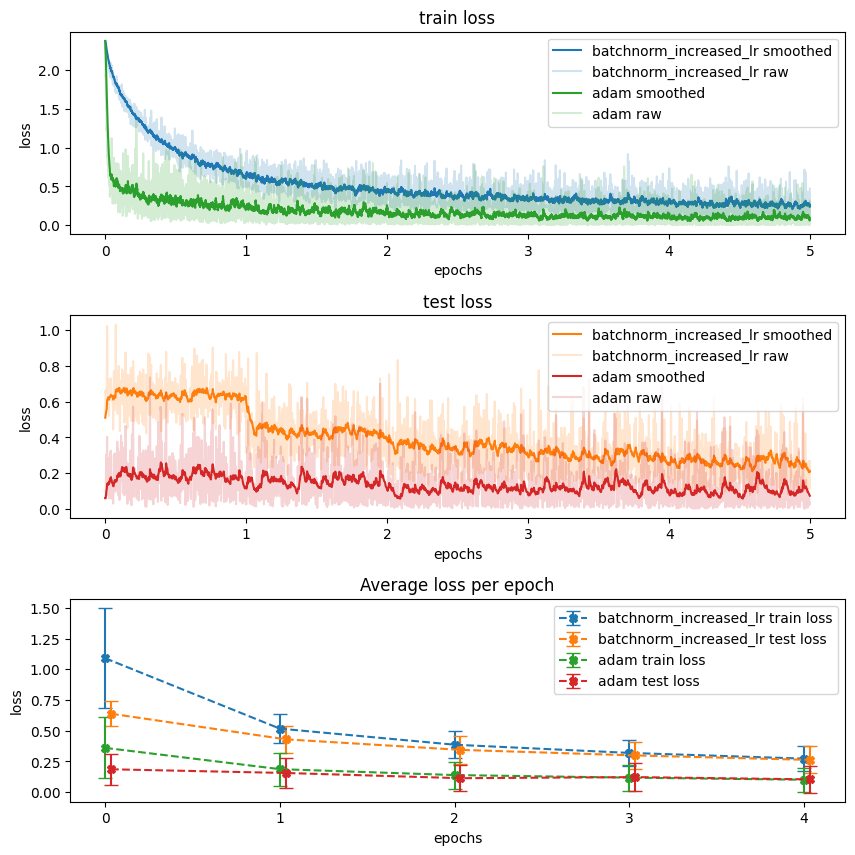

In [ ]:
history_plotter.plot(["batchnorm_increased_lr", model_name])

### L2 vs Weight decay

–î–ª—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è L2 c –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ —É–∫–∞–∑–∞—Ç—å –∑–Ω–∞—á–µ–Ω–∏–µ `weight_decay`,  –≥–¥–µ `weight_decay` ‚Äî –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –ø–µ—Ä–µ–¥ L2.

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop([parameters], alpha=0.99, weight_decay=0.001)

–í–æ–æ–±—â–µ –≥–æ–≤–æ—Ä—è, **Weight decay** –∏ **L2** ‚Äî —ç—Ç–æ –Ω–µ–º–Ω–æ–≥–æ —Ä–∞–∑–Ω—ã–µ –≤–µ—â–∏.

**L2** –¥–æ–±–∞–≤–ª—è–µ—Ç —á–ª–µ–Ω —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏ –∫ Loss —Ñ—É–Ω–∫—Ü–∏–∏:

$$\text{Loss}_{L2} = \text{Loss} + \frac{Œª}{2n}w^2$$

**Weight decay** —É–º–µ–Ω—å—à–∞–µ—Ç –≤–µ—Å–∞:

$$w_{wd} = w - \frac{Œª}{n}w$$

–≥–¥–µ $Œª$ ‚Äî –∫–æ–Ω—Å—Ç–∞–Ω—Ç–∞, –∞ $n$ ‚Äî –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ª–µ–º–µ–Ω—Ç–æ–≤ –≤ –±–∞—Ç—á–µ.


–î–ª—è **SGD** –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ **Weight decay** –∏ **L2** **—ç–∫–≤–∏–≤–∞–ª–µ–Ω—Ç–Ω—ã**, –Ω–æ –Ω–µ –¥–ª—è –≤—Å–µ—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤ —ç—Ç–æ —Ç–∞–∫.

–ù–∞–ø—Ä–∏–º–µ—Ä, —ç—Ç–æ –Ω–µ —Ç–∞–∫ –¥–ª—è **Adam**. **L2**-—Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è –ø—Ä–∏–±–∞–≤–ª—è–µ—Ç—Å—è –∫ Loss —Ñ—É–Ω–∫—Ü–∏–∏ –∏ –∏–∑–º–µ–Ω—è–µ—Ç **–∑–Ω–∞—á–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞**, –∫–≤–∞–¥—Ä–∞—Ç—ã –∫–æ—Ç–æ—Ä–æ–≥–æ –±—É–¥—É—Ç —Ö—Ä–∞–Ω–∏—Ç—å—Å—è. **Weight decay** –∏–∑–º–µ–Ω—è–µ—Ç —Ç–æ–ª—å–∫–æ –≤–µ—Å–∞. –ü–æ–¥—Ä–æ–±–Ω–æ –æ–± —ç—Ç–æ–º –º–æ–∂–Ω–æ –ø–æ—á–∏—Ç–∞—Ç—å –≤:

[[arxiv] üéì Decoupled Weight Decay Regularization (Loshchilov, Hutter, 2019)](https://arxiv.org/pdf/1711.05101.pdf)

**–û–±—Ä–∞—Ç–∏—Ç–µ –≤–Ω–∏–º–∞–Ω–∏–µ**, —á—Ç–æ `weight_decay` –≤ `torch.optim.Adam` ‚Äî —ç—Ç–æ **–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –ø–µ—Ä–µ–¥ L2**. **Weight decay** –¥–ª—è **Adam** —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–æ –≤
`torch.optim.AdamW`.


### –î—Ä—É–≥–∏–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä—ã (Lion)

–ï—Å—Ç—å –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω—ã–µ –º–µ—Ç–æ–¥—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏, –Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–æ–µ–∫—Ç [Google Brain ‚úèÔ∏è[blog]](https://research.google/teams/brain/) –≤ 2023 –≥–æ–¥—É –æ–ø—É–±–ª–∏–∫–æ–≤–∞–ª [—Å—Ç–∞—Ç—å—é üéì[arxiv]](https://arxiv.org/pdf/2302.06675.pdf), –≤ –∫–æ—Ç–æ—Ä–æ–π –æ–ø–∏—Å—ã–≤–∞–µ—Ç –Ω–∞–π–¥–µ–Ω–Ω—ã–π –≤ –ø—Ä–æ—Ü–µ—Å—Å–µ [AutoML üéì[arxiv]](https://arxiv.org/pdf/2101.08809.pdf) (–∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–≥–æ –ø–æ–¥–±–æ—Ä–∞ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä –∏ –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤) –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä, –Ω–∞–∑–≤–∞–Ω–Ω—ã–π **Lion**  (Evo**L**ved S**i**gn M**o**me**n**tum).

–ò–Ω—Ç–µ—Ä–µ—Å–Ω–æ, —á—Ç–æ AutoML –∞–ª–≥–æ—Ä–∏—Ç–º –ø—Ä–∏—à–µ–ª –∫ –∏–Ω—Ç—É–∏—Ç–∏–≤–Ω–æ –ø–æ–Ω—è—Ç–Ω–æ–π —ç–≤—Ä–∏—Å—Ç–∏–∫–µ: –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã ‚Äî –≤–µ—â—å –Ω–µ –æ—á–µ–Ω—å –Ω–∞–¥–µ–∂–Ω–∞—è. –û–Ω–∏ –º–æ–≥—É—Ç –≤–∑—Ä—ã–≤–∞—Ç—å—Å—è –∏ –∑–∞—Ç—É—Ö–∞—Ç—å. –ú–æ–∂–µ—Ç, —Ç–æ–≥–¥–∞ –º—ã –∑–∞—Ñ–∏–∫—Å–∏—Ä—É–µ–º —Ä–∞–∑–º–µ—Ä —à–∞–≥–∞, –∞ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ç–æ–ª—å–∫–æ –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è?

–î–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è –∏—Å–ø–æ–ª—å–∑—É—é—Ç —Ñ—É–Ω–∫—Ü–∏—é $\text{sign}$ (–∑–Ω–∞–∫):

\begin{align}
\text{sign}(x) = \left\{
\begin{array}{cl}
1 & x > 0 \\
0 & x = 0\\
-1 & x < 0.
\end{array}
\right.
\end{align}


–ö —ç—Ç–æ–º—É –¥–æ–±–∞–≤–ª—è–µ—Ç—Å—è —É–∂–µ –∏–∑—É—á–µ–Ω–Ω—ã–π –Ω–∞–º–∏ momentum, —á—Ç–æ–±—ã –∑–Ω–∞–∫ ‚Äú–ø—Ä—ã–≥–∞–ª‚Äù —Ä–µ–∂–µ. –ò–Ω—Ç–µ—Ä–µ—Å–Ω–æ, —á—Ç–æ AutoML –ø–æ–¥–æ–±—Ä–∞–ª –∞–ª–≥–æ—Ä–∏—Ç–º, –≤ –∫–æ—Ç–æ—Ä–æ–º –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –¥–≤–µ –∫–æ–Ω—Å—Ç–∞–Ω—Ç—ã –¥–ª—è momentum. $\beta_1$ ‚Äî –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–µ–∫—É—â–µ–≥–æ –∑–Ω–∞–∫–∞ –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞, $\beta_2$ ‚Äî –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –∑–Ω–∞—á–µ–Ω–∏—è $v_t$. –ó–Ω–∞—á–µ–Ω–∏—è –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é $\beta_1 = 0.9$, $\beta_2 = 0.99$. –≠—Ç–æ –∑–Ω–∞—á–∏—Ç, —á—Ç–æ —Ç–µ–∫—É—â–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–∞ —Å–∏–ª—å–Ω–µ–µ –≤–ª–∏—è–µ—Ç –Ω–∞ –∑–Ω–∞—á–µ–Ω–∏–µ –¥–ª—è –≤—ã–±–æ—Ä–∞ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è —Ç–µ–∫—É—â–µ–≥–æ —à–∞–≥–∞ $c_{t}$, —á–µ–º –Ω–∞ —Ö—Ä–∞–Ω–∏–º–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –º–æ–º–µ–Ω—Ç–∞ $v_t$.


–ó–Ω–∞—á–µ–Ω–∏–µ –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è —Ç–µ–∫—É—â–µ–≥–æ —à–∞–≥–∞:

$$c_{t} = \beta_1 \cdot v_{t-1} + (1-\beta_1) \nabla_wL(x, y, w_{t})$$

–®–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞. $Œª$ ‚Äî –∫–æ–Ω—Å—Ç–∞–Ω—Ç–∞ weight decay:

$$w_{t+1} = w_t - \text{lr} \cdot (\text{sign}(c_t) +Œª w_t)$$

–û–±–Ω–æ–≤–ª–µ–Ω–∏–µ —Ö—Ä–∞–Ω–∏–º–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –º–æ–º–µ–Ω—Ç–∞:

$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \nabla_wL(x, y, w_{t})$$

–§—Ä–∞–≥–º–µ–Ω—Ç –∫–æ–¥–∞ –¥–ª—è –ø–æ–Ω–∏–º–∞–Ω–∏—è —Ä–∞–±–æ—Ç—ã **Lion**:

```python
class Lion:
  def __init__(self, parameters, lr=0.0001, betas=(0.9, 0.99), weight_decay=0.01):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum 1
    self.beta_2 = betas[1] # momentum 2
    self.weight_decay = weight_decay

  def step(self):
    d_parameters = self.parameters.grad
    # current momentum
    current = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # step
    self.parameters -= self.lr*(torch.sign(carent)+self.weight_decay*self.parameters)
    # history momentum
    self.velocity = self.beta_2*self.velocity + (1 - self.beta_2)*d_parameters
```

**Lion —É–¥–≤–∞–∏–≤–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.**

–û–±—Ä–∞—Ç–∏—Ç–µ –≤–Ω–∏–º–∞–Ω–∏–µ, —á—Ç–æ –∑–Ω–∞—á–µ–Ω–∏–µ lr –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é —É **Lion** –≤—ã–±—Ä–∞–Ω–æ –º–µ–Ω—å—à–µ, —á–µ–º —É **Adam**. –≠—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ —Ç–æ–ª—å–∫–æ lr –∏ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è –æ–ø—Ä–µ–¥–µ–ª—è—é—Ç —Ä–∞–∑–º–µ—Ä —à–∞–≥–∞. –ê–≤—Ç–æ—Ä—ã —Å—Ç–∞—Ç—å–∏ —Å–æ–≤–µ—Ç—É—é—Ç –±—Ä–∞—Ç—å –¥–ª—è **Lion** –≤ 10 —Ä–∞–∑ –º–µ–Ω—å—à–∏–π lr, —á–µ–º –¥–ª—è **Adam**.

–£ **Lion** –µ—Å—Ç—å –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å **Adam** –∏ **AdamW**: –≤ –Ω–µ–º –Ω–µ—Ç –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç–∏ —Ö—Ä–∞–Ω–∏—Ç—å –∫–≤–∞–¥—Ä–∞—Ç—ã –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤. –û–Ω –ø–æ–∑–≤–æ–ª—è–µ—Ç **—Å–Ω–∏–∑–∏—Ç—å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤** –≤ 1.5‚Äì2 —Ä–∞–∑–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å **AdamW**, –∞ —Ç–∞–∫–∂–µ —Å–æ–∫—Ä–∞—â–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–ø–µ—Ä–∞—Ü–∏–π, —á—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç [—É—Å–∫–æ—Ä–∏—Ç—å —Ä–∞—Å—á–µ—Ç—ã –Ω–∞ 2‚Äì15% üéì[arxiv]](https://arxiv.org/pdf/2302.06675.pdf) (–≤ Colab —ç—Ç–æ –Ω–µ–∑–∞–º–µ—Ç–Ω–æ –∏–∑-–∑–∞ —Å–ø–µ—Ü–∏—Ñ–∏–∫–∏, —Å–≤—è–∑–∞–Ω–Ω–æ–π —Å –≤–∏—Ä—Ç—É–∞–ª—å–Ω—ã–º–∏ –º–∞—à–∏–Ω–∞–º–∏).

–ö—Ä–æ–º–µ —Ç–æ–≥–æ, **Lion** [–ø–æ–∑–≤–æ–ª—è–µ—Ç –¥–æ–±–∏—Ç—å—Å—è –ª—É—á—à–∏—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ üêæ[git]](https://github.com/google/automl/tree/master/lion), —á–µ–º AdamW, –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –±–æ–ª—å—à–∏—Ö —Å–ª–æ–∂–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π, —Ç–∞–∫–∏—Ö –∫–∞–∫ Visual Transformer-—ã –∏ –¥–∏—Ñ—Ñ—É–∑–∏–æ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏.

–ù–æ –¥–æ —Å–ª–æ–∂–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –º—ã –ø–æ–∫–∞ –Ω–µ –¥–æ–±—Ä–∞–ª–∏—Å—å, –ø–æ–ø—Ä–æ–±—É–µ–º –ø—Ä–æ—Å—Ç—É—é. –í–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–µ–π [Lion-Pytorch üêæ[git]](https://github.com/lucidrains/lion-pytorch):

In [ ]:
!pip install -q lion-pytorch

In [ ]:
from lion_pytorch import Lion

model_name = "lion"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=Lion,
    optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-3},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


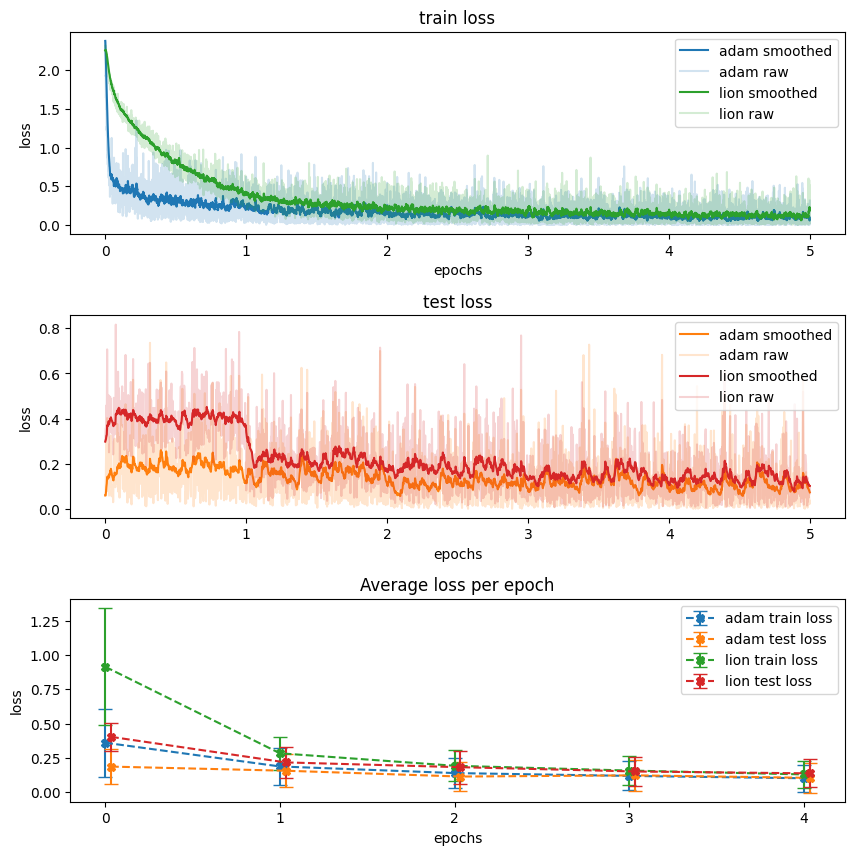

In [ ]:
history_plotter.plot(["adam", model_name])

–†–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ–ª—É—á–∏–ª—Å—è –ø–æ—á—Ç–∏ –∫–∞–∫ —É **Adam**, —á–∏—Å–ª–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–µ–Ω—å—à–µ. –î–ª—è –ª—É—á—à–µ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞ —Å Lion —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å `lr_scheduler`, —á—Ç–æ–±—ã –ø–æ—Å—Ç–µ–ø–µ–Ω–Ω–æ –ø–æ–Ω–∏–∂–∞—Ç—å —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è.



## –õ–∞–Ω–¥—à–∞—Ñ—Ç —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å


–°—É—â–µ—Å—Ç–≤—É–µ—Ç [–∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ üéì[article]](https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf), –∫–æ—Ç–æ—Ä–æ–µ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ –ª–∞–Ω–¥—à–∞—Ñ—Ç —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π –Ω–µ –∏–∑–æ–ª–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ª–æ–∫–∞–ª—å–Ω—ã–µ –º–∏–Ω–∏–º—É–º—ã (—Ä–∏—Å—É–Ω–æ–∫ —Å–ª–µ–≤–∞), –∞ —Å–≤—è–∑–∞–Ω–Ω—ã–µ –æ–±–ª–∞—Å—Ç–∏ —Å –ø–æ—á—Ç–∏ –ø–æ—Å—Ç–æ—è–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º (—Ä–∏—Å—É–Ω–æ–∫ —Å–ø—Ä–∞–≤–∞). –ü–æ—ç—Ç–æ–º—É —É–º–µ–Ω–∏–µ ‚Äú–≤—ã–±–∏—Ä–∞—Ç—å—Å—è‚Äù –∏–∑ —Å–µ–¥–ª–æ–≤—ã—Ö —Ç–æ—á–µ–∫ –≤–∞–∂–Ω–æ.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/loss_surfaces.png" width="900"></center>

<center><em>Source: <a href="https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf">Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs</a></em></center>

## –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤

–£ –∫–∞–∂–¥–æ–≥–æ –∏–∑ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–Ω—ã—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤ –µ—Å—Ç—å –º–∏–Ω—É—Å—ã –∏ –ø–ª—é—Å—ã:

* –ú–µ—Ç–æ–¥—ã —Å –∏–Ω–µ—Ä—Ü–∏–µ–π —Å—Ö–æ–¥—è—Ç—Å—è –∫ —Ä–µ—à–µ–Ω–∏—é –±–æ–ª–µ–µ –ø–ª–∞–≤–Ω–æ, –Ω–æ –º–æ–≥—É—Ç "–ø–µ—Ä–µ–ª–µ—Ç–∞—Ç—å".
* –ú–µ—Ç–æ–¥—ã —Å –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–º learning rate –±—ã—Å—Ç—Ä–µ–µ —Å—Ö–æ–¥—è—Ç—Å—è, –±–æ–ª–µ–µ —Å—Ç–∞–±–∏–ª—å–Ω—ã –∏ –º–µ–Ω—å—à–µ —Å–ª—É—á–∞–π–Ω–æ –±–ª—É–∂–¥–∞—é—Ç.
* –ê–ª–≥–æ—Ä–∏—Ç–º—ã –±–µ–∑ –∞–¥–∞–ø—Ç–∏–≤–Ω–æ–≥–æ learning rate —Å–ª–æ–∂–Ω–µ–µ –≤—ã–±–∏—Ä–∞—é—Ç—Å—è –∏–∑ –ª–æ–∫–∞–ª—å–Ω—ã—Ö –º–∏–Ω–∏–º—É–º–æ–≤.
* –ê–ª–≥–æ—Ä–∏—Ç–º—ã —Å –∏–Ω–µ—Ä—Ü–∏–µ–π –æ—Å—Ü–∏–ª–∏—Ä—É—é—Ç –≤ —Å–µ–¥–ª–æ–≤—ã—Ö —Ç–æ—á–∫–∞—Ö –ø—Ä–µ–∂–¥–µ, —á–µ–º –Ω–∞—Ö–æ–¥—è—Ç –≤–µ—Ä–Ω—ã–π –ø—É—Ç—å.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/methods_without_adaptive_learning_rate.gif" width="450"><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/methods_with_momentum_in_saddle_point.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em></center>